# 12.4 Generating images with variational autoencoders

当今创意人工智能最受欢迎和最成功的应用是图像生成：学习潜在的视觉空间并从中取样，以创建从真实图像中插入的全新图片——想象中的人、想象中的地方、想象中的猫和狗的图片等。

在本节和下一节中，我们将回顾一些与图像生成相关的高级概念，以及与该领域两个主要技术相关的实现细节：变分自编码器（VAE）和生成对抗网络（GAN）。请注意，我在这里介绍的技术并非特定于图像——您可以使用GAN和VAE开发声音、音乐甚至文本的潜在空间——但在实践中，最有趣的结果是通过图片获得的，这就是我们在这里关注的。

## 12.4.1 Sampling from latent spaces of images

图像生成的关键想法是开发一个低维度的表征空间（与深度学习中的其他内容一样，这是一个矢量空间），其中任何点都可以映射到“有效”图像：看起来像真实事物的图像。能够实现此映射的模块，以 latent point 和输出图像（像素网格）作为输入，称为生成器（在GAN的情况下）或解码器（在VAE的情况下）。一旦学习了这样一个潜在空间，您可以从中采样点，并通过将它们映射回图像空间，生成以前从未见过的图像（见图12.13）。这些新图像是训练图像的中间。

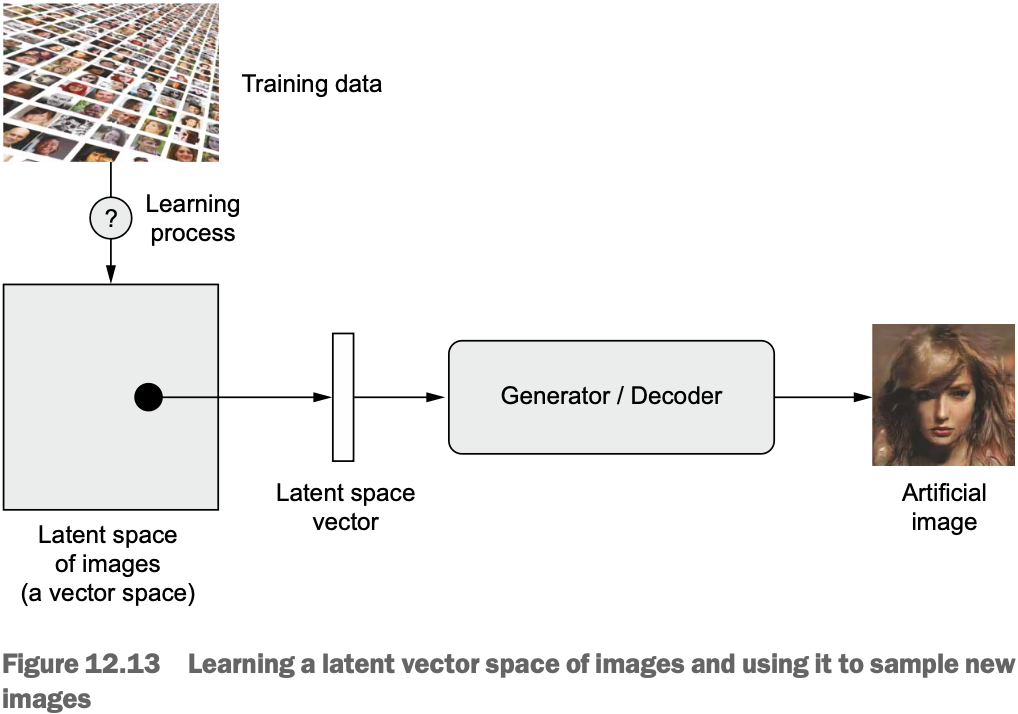

GAN和VAE是学习图像表示潜空间的两种不同策略，每种方法都有自己的特征。 VAE 更擅长于学习具有非常好结构化的隐空间， 其中特定方向编码了数据中有意义的变化轴(见图 12.14)。 GAN生成的图像可以高度逼真，但它们来自的潜在空间可能没有那么多的结构和连续性。 

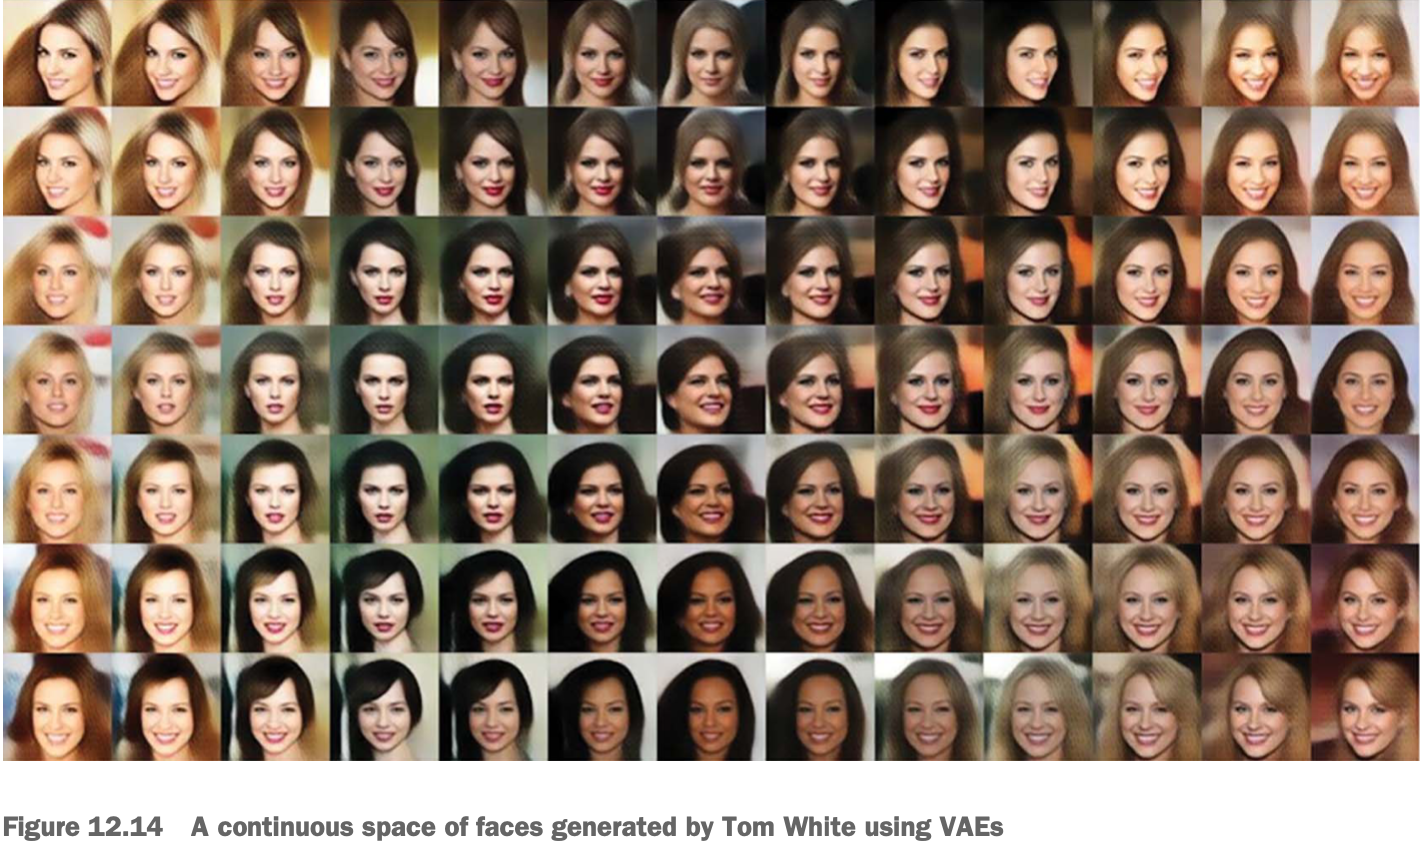

## 12.4.2 Concept vectors for image editing

当我们在第11章中涵盖单词嵌入时，我们已经暗示了 `concept vector` 的想法。这个想法仍然是一样的：给定一个潜在的表示空间或嵌入空间，空间中的某些方向可能会在原始数据中编码有趣的变量轴。例如，在人脸图像的潜在空间中，可能有一个 `smile vector`，例如，如果 latent point z 是特定面孔的嵌入式表示形式，那么 latent point z + s是同一面孔的嵌入式表示，微笑。

一旦您识别了这样的矢量，就可以通过将图像投影到潜在空间，以有意义的方式移动其表示形式，然后将其解码回图像空间来编辑图像。有图像空间变化的任何独立维度的概念矢量——就人脸而言，您可能会发现向面部添加太阳镜、摘下眼镜、将男性脸变成女性脸等的矢量。图12.15是来自新西兰维多利亚大学设计学院的Tom White发现的微笑矢量的例子，该矢量使用在名人面孔数据集（CelebA数据集）上训练的VAE。

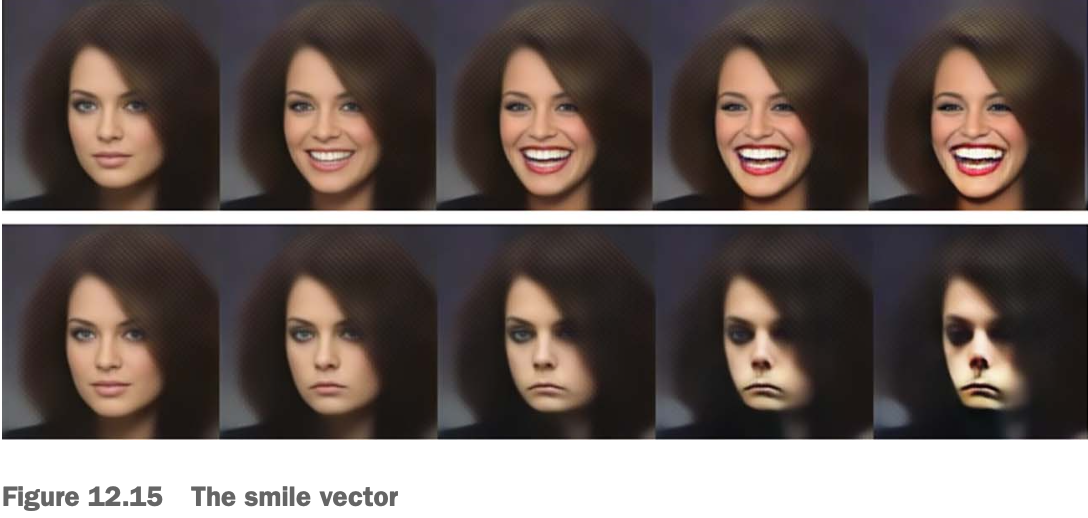

## 12.4.3 Variational autoencoders

Kingma 和 Welling于2013年12月以及Rezende、Mohamed和Wierstra于2014年1月6同时发现的变分自编码器是一种生成模型，特别适合通过 concept vector 进行图像编辑任务。 它们是一种现代的自编码器（一种网络，旨在将输入编码到低维潜在空间，然后将其解码），将深度学习的想法与贝叶斯推理混合在一起。

传统的图像自编码器获取图像，通过编码器模块将其映射到潜矢量空间，然后通过解码器模块将其解码回与原始图像相同尺寸的输出（见图12.16）。然后，它通过使用与输入图像相同的图像作为目标数据进行训练，这意味着自编码器学习重建原始输入。通过对代码施加各种约束（编码器的输出），您可以让自编码器了解或多或少有趣的数据潜在表示。最常见的是，您将代码限制为低维度和稀疏（主要是零），在这种情况下，编码器可以将输入数据压缩为更少位的信息。

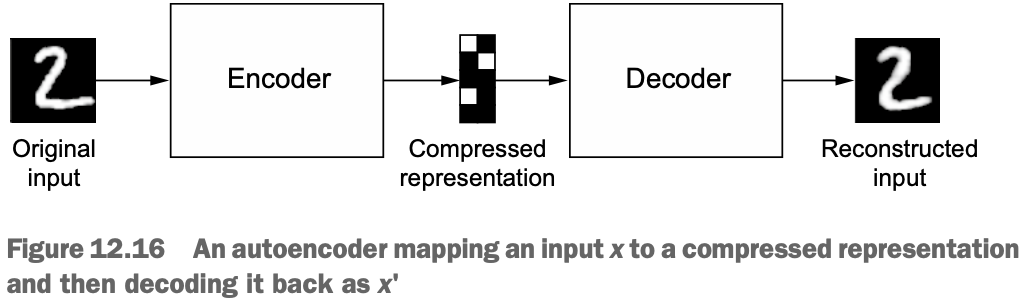

在实践中，这种经典的自编码器不会生成特别有用或结构良好的潜空间。 它们也不太擅长压缩。由于这些原因，他们基本上已经过时了。然而，VAE用一点统计魔法增强了自编码器，迫使他们学习连续的、高度结构化的潜空间。它们被证明是生成图像的强大工具。

VAE不是将其输入图像压缩为潜空间中的固定编码，而是将图像转换为统计分布的参数：均值和方差。从本质上讲，这意味着我们假设输入图像是由统计过程生成的，并且在编码和解码过程中应考虑到该过程的随机性。然后，VAE使用均值和方差参数随机采样分布的一个元素，并将该元素解码回原始输入(见图12.17)。这种处理的随机性提高了鲁棒性，并迫使潜空间在任何地方编码有意义的表征：在潜在空间中采样的每个点都被解码为有效的输出。

从技术上讲，VAE的工作原理如下：

- 编码器模块将输入示例 `input_img` 转换为表示潜空间中的两个参数，`z_mean` 和 `z_log_variance`。
- 您从假设生成输入图像的潜正态分布中随机采样点z，通过 `z=z_mean+exp(z_log_variance)* epsilon`，其中 `epsilon` 是很小的随机张量。
- 解码器模块将潜空间中的此点映射回原始输入图像。

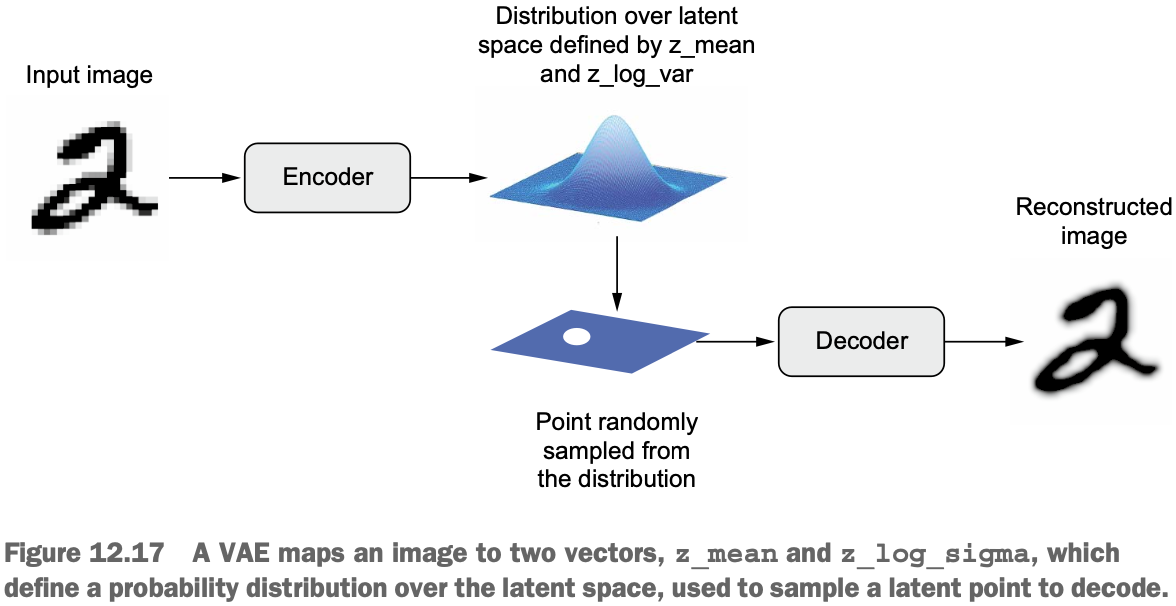


由于 `epsilon` 是随机的，该过程确保接近您编码 `input_img(z-mean)` 的潜在位置的每个点都可以解码为类似于`input_img` 的东西，从而迫使潜空间连续有意义。潜空间中的任何两个近点都将解码为高度相似的图像。连续性，加上潜空间的低维度，迫使潜在空间的每个方向编码有意义的数据变化轴，使潜空间非常结构化，因此非常适合通过概念向量进行操作。

VAE的参数通过两个损失函数进行训练：强制解码样本与初始输入匹配的重建损失，以及帮助学习全面的潜在分布并减少过拟合训练数据的正则化损失。从原理上讲，这个过程是这样的：

```python
z_mean, z_log_variance = encoder(input_img)
z = z_mean + exp(z_log_variance) * epsilon
reconstructed_img = decoder(z)
model = Model(input_img, reconstructed_img)
```

然后，您可以使用重建损失和正则化损失来训练模型。对于正则化损失，我们通常使用一个表达式（KL 散度），旨在将编码器输出的分布推向以 0 为中心的四舍五入的正态分布。这为编码器提供了关于其建模的潜空间结构的合理假设。

现在让我们看看在实践中VAE是什么样子的！


## 12.4.4 Implementing a VAE with Keras

我们将实施一个可以生成MNIST数字的VAE。它将分为三部分：

- 将真实图像转换为潜空间的均值和方差的编码器网络
- 采样层，接受这样的均值和方差，并使用它们从潜空间取样随机点
- 将点从潜空间转回图像的解码器网络

以下列表显示了我们将使用的编码器网络，将图像映射到潜空间上概率分布的参数。这是一个简单的convnet，将输入图像x映射到两个向量，`z_mean` 和 `z_log_var`。一个重要的细节是，我们使用 stride 来下采样特征图，而不是最大池化。我们最后一次这样做是在第9章的图像分割示例中。请记住，一般来说，对于任何关心信息位置的模型（即图像中的东西在哪里）来说，stride 比最大池化要好，而这个模型确实如此，因为它必须生成可用于重建有效图像的图像编码。

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(
    32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [5]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

接下来是使用 `z_mean` 和 `z_log_var` 的代码，这些参数假设已生成 `input_img`，以生成潜空间点 `z`。

In [6]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

以下列表显示了解码器的实现。我们将矢量 `z` 重塑为图像的尺寸，然后使用几个卷积层来获得与原始 `input_img` 尺寸相同的最终图像输出。

In [8]:
latent_inputs = keras.Input(shape=(latent_dim, ))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [9]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

现在让我们自己创建VAE模型。这是您第一个不进行监督学习的模型示例（自编码器是自监督学习的示例，因为它使用其输入作为目标）。每当您离开经典的监督学习时，通常都会对 `Model` 类进行子类，并实现自定义 `train_ step()` 来指定新的训练逻辑，这是您在第7章中学习的工作流程。这就是我们在这里要做的。

In [22]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "total_loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()
            }

最后，我们准备在MNIST数字上实例化和训练模型。由于损失是在自定义层中处理的，因此我们不会在编译时指定外部损失（`loss=None`），这反过来意味着我们不会在训练期间传递目标数据（如您所见，我们只将 `x_train` 传递给的模型的 `fit()`)。

In [23]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 18s 32ms/step - total_loss: 197.7872 - reconstruction_loss: 195.5994 - kl_loss: 2.1876
Epoch 2/30
547/547 [==============================] - 17s 31ms/step - total_loss: 162.6970 - reconstruction_loss: 159.7473 - kl_loss: 2.9496
Epoch 3/30
547/547 [==============================] - 17s 31ms/step - total_loss: 157.7638 - reconstruction_loss: 154.6436 - kl_loss: 3.1202
Epoch 4/30
547/547 [==============================] - 17s 31ms/step - total_loss: 155.1846 - reconstruction_loss: 151.9387 - kl_loss: 3.2459
Epoch 5/30
547/547 [==============================] - 17s 31ms/step - total_loss: 153.4087 - reconstruction_loss: 150.0837 - kl_loss: 3.3251
Epoch 6/30
547/547 [==============================] - 17s 31ms/step - total_loss: 152.1333 - reconstruction_loss: 148.7586 - kl_loss: 3.3747
Epoch 7/30
547/547 [==============================] - 17s 31ms/step - total_loss: 151.0933 - reconstruction_loss: 147.6870 - kl_loss: 3.4064
Epoch 8/30
54

一旦模型训练好，我们可以使用解码器网络将任意的潜空间向量转换为图像。

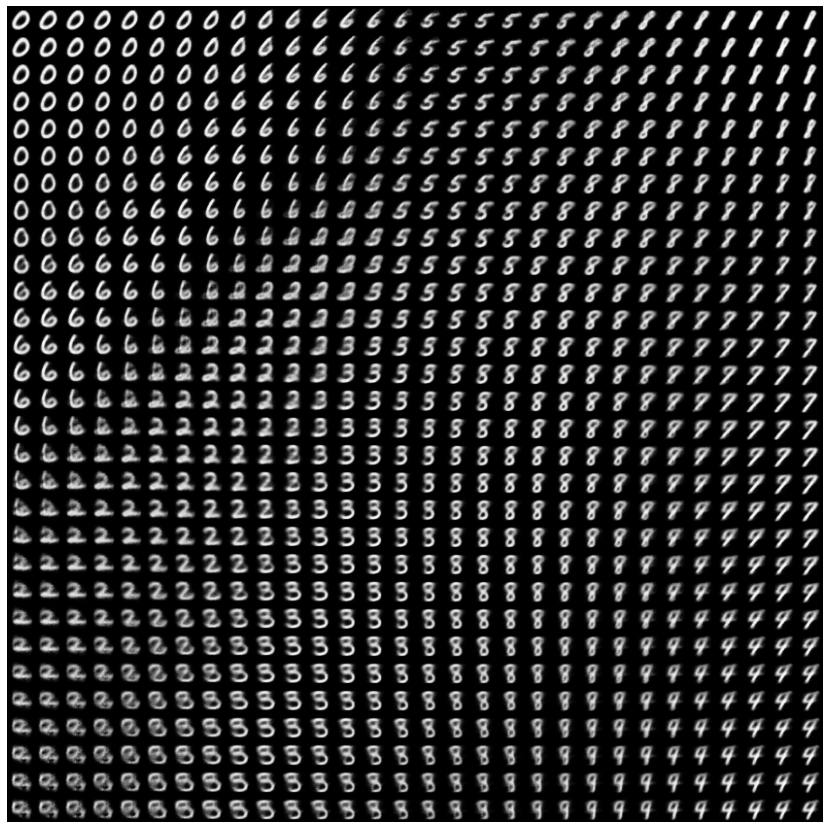

In [33]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size,
               j * digit_size : (j + 1) * digit_size,
        ] = digit
        
plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size) 
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

采样数字网格显示了不同数字类的完全连续的分配，当你沿着路径穿过潜空间时，一个数字会变形为另一个数字。这个空间中的具体方向有一个含义：例如，有“five-ness”、“one-ness” 等方向。

在下一节中，我们将详细介绍另一个用于生成人工图像的主要工具：生成对抗网络（GAN）。

## 12.4.5 Warpping up

- 通过深度学习生成图像是通过学习捕获图像数据集统计信息的潜空间来完成的。通过对潜空间的采样和解码，您可以生成从未见过的图像。有两种主要工具可以做到这一点：VAE和GAN。
- VAE导致高度结构化、连续的潜表示。由于这个原因，他们很好地在潜空间中进行各种图像编辑：换脸、把皱眉的脸变成笑脸等等。它们还很好地用于制作基于潜空间的动画，例如动画沿着潜空间的横截面散步，或以连续的方式显示初始图像缓慢变形为不同的图像。
- GAN可以生成逼真的单帧图像，但可能不会诱导具有坚实结构和高连续性的潜空间。

我在图像中看到的大多数成功的实际应用都依赖于VAE，但GAN在学术研究领域一直很受欢迎。您将了解它们是如何工作的，以及如何在下一节中实现它们。